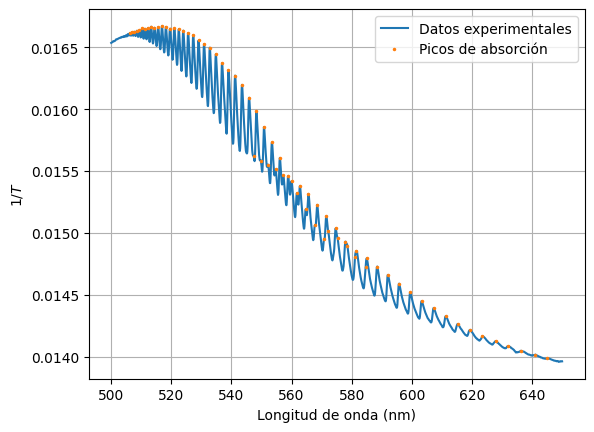

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import vectorize,array,mean, where,transpose,log,append,arange,vectorize,pi,concatenate,sort

def filtro1(x,y,h):
  i=0
  rx=[]
  ry=[]

  while x[i]+h<x[-1]:
    ux=[]
    uy=[]
    j=i
    while x[i]<=x[j]<=x[i]+h:
      ux.append(x[j])
      uy.append(y[j])
      j+=1
    i=j
    rx.append(mean(ux))
    ry.append(mean(uy))
  ux=x[i:]
  uy=y[i:]
  rx.append(mean(ux))
  ry.append(mean(uy))
  return transpose(array([array(rx),array(ry)]))


def filtro2(x,y,j,tol):
  u=1e-20
  mx=[]
  my=[]
  for i in range(j,len(x)-j):
    k=y[i]-y[i-j:i+j]
    kad=y[i]-y[i:i+j]
    kat=y[i]-y[i-j:i]
    if (mean(k)>tol and all(k>=0)):
      mx.append(x[i])
      my.append(y[i])

  return transpose(array([array(mx),array(my)]))

d=pd.read_csv("Sheet1.dat",sep="\t").values
a=transpose(array([d[:,0],d[:,2]]))

i1=where(a[:,0]>544.8)[0][0]
i2=where(a[:,0]>587.6)[0][0]

d1=transpose(array([a[:i1,0],a[:i1,1]]))
m1=filtro2(d1[:,0],d1[:,1],5,0.00001)

d2=transpose(array([a[i1:i2,0],a[i1:i2,1]]))
m2=filtro2(d2[:,0],d2[:,1],5,0.00001)

d3=transpose(array([a[i2:,0],a[i2:,1]]))
m3=filtro2(d3[:,0],d3[:,1],7,0.000001)

n0amano=array([[567.8,0.0150611482619435],
               [570.9,0.0149508118290823]])

n1amano=array([
[547.4,0.0156181670519148],
[549.8,0.0155833632014461],
[581.1,0.0148045064917761],
[584.6,0.0147268898281372]])

n2amano=array([
  [572.2,0.0150116340163627],
  [575.3,0.0149572969173011],
  [578.6,0.0148920327624721]])

np0long=concatenate([m1[:,0],m2[:3,0],m2[4:14:2,0],n0amano[:,0]])
np1long=concatenate([n1amano[:,0],m2[3:15:2,0],[m2[14,0]],m2[15:18,0]])
np2long=concatenate([n2amano[:,0],m2[18:,0],m3[:,0]])

d=append(append(d1,d2,axis=0),d3,axis=0)
m=concatenate([m1,m2,m3[:],n2amano,n1amano,n0amano],axis=0)

plt.plot(d[:,0],d[:,1],"-",markersize=1,label="Datos experimentales")
plt.plot(m[:,0],m[:,1],".",markersize=3,label="Picos de absorción")

plt.ylabel(r"$1/T$")
plt.xlabel("Longitud de onda (nm)")
plt.legend()

plt.grid()
plt.show()

omega':   126.7118173618006    +-0.7502673157028187
ji':   0.00739244304704722    +-5.843027084949128e-05


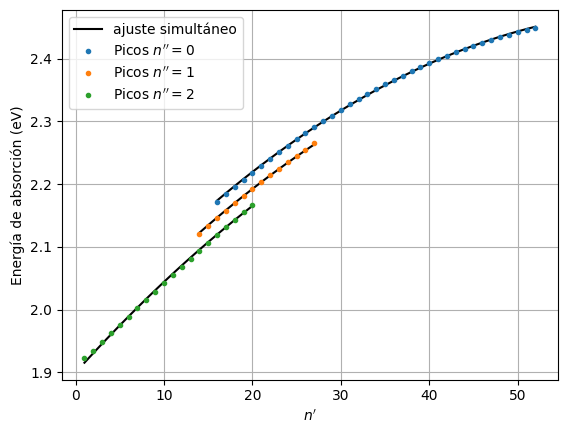

In [37]:
from numpy import std,linspace,zeros
from numpy.random import normal
from scipy.optimize import minimize
np0long=sort(np0long)[::-1]
np1long=sort(np1long)[::-1]
np2long=sort(np2long)[::-1]

h=6.62607015e-34
hbarra=h/(2*pi)
c=299792458
eVaJ=1.602176634e-19

t=lambda x: (h*c/(x*1e-9))/eVaJ
E0=vectorize(t)(np0long)
E1=vectorize(t)(np1long)
E2=vectorize(t)(np2long)

errorE0=E0*0.5/np0long
errorE1=E1*0.5/np1long
errorE2=E2*0.5/np2long

nd0=24
i0=where(E0==t(548.3))[0][0]
npp0=arange(nd0-i0,nd0-i0+len(E0))

dif=len(E2)-len(E1)

u=zeros((11,11))

for j in range(0,11):
  k1=E1[j:]-E0[:len(np1long[j:])]
  for s in range(0,11):
    k2=E2[s+dif:]-E1[:len(E2[s+dif:])]
    u[j,s]=(std(k1)**2+std(k2)**2+(mean(k1)-mean(k2))**2)

indices=where(u==u.min())
i1=indices[0][0]
i2=indices[1][0]+dif

npp1=(npp0-i1)[:len(np1long)]
npp2=(npp0-i2-i1)[:len(np2long)]

def chicuad(x,E0,E1,E2):
    sum=0
    f=lambda a,b,c,x: a+b*(x+0.5)+c*(x+0.5)**2
    for i in range(len(E0)):
      sum+=(f(x[0],x[3],x[4],npp0[i])-E0[i])**2
    for i in range(len(E1)):
      sum+=(f(x[1],x[3],x[4],npp1[i])-E1[i])**2
    for i in range(len(E2)):
      sum+=(f(x[2],x[3],x[4],npp2[i])-E2[i])**2
    return sum

om=[]
chi=[]
acero=[]
auno=[]
ados=[]
for i in range(1000):
  c0=E0+vectorize(normal)(0,errorE0)
  c1=E1+vectorize(normal)(0,errorE1)
  c2=E2+vectorize(normal)(0,errorE2)
  res=minimize(lambda x: chicuad(x,c0,c1,c2),[1.95,1.922,1.90,1.54637325e-02,-1.12615552e-04]).x

  acero.append(res[0])
  auno.append(res[1])
  ados.append(res[2])
  om.append(res[3]*eVaJ/(100*c*h))
  chi.append(-res[4]/res[3])
era0,era1,era2,erroromega,errorchi=std(acero),std(auno),std(ados),std(om),std(chi)

res=minimize(lambda x: chicuad(x,E0,E1,E2),[t(640),t(640),t(640),0.015,-0.000114]).x


x0=linspace(npp0[0],npp0[-1])
x1=linspace(npp1[0],npp1[-1])
x2=linspace(npp2[0],npp2[-1])

y0=res[0]+res[3]*(x0+0.5)+res[4]*(x0+0.5)**2
y1=res[1]+res[3]*(x1+0.5)+res[4]*(x1+0.5)**2
y2=res[2]+res[3]*(x2+0.5)+res[4]*(x2+0.5)**2

print("omega':   "+str(res[3]*eVaJ/(100*c*h))+"    +-"+str(erroromega))
print("ji':   "+str(-res[4]/res[3])+"    +-"+str(errorchi))



plt.plot(x0,y0,color="black",label="ajuste simultáneo")
plt.plot(x1,y1,color="black")
plt.plot(x2,y2,color="black")

plt.plot(npp0,E0,".",label=r"Picos $n''=0$")
plt.plot(npp1,E1,".",label=r"Picos $n''=1$")
plt.plot(npp2,E2,".",label=r"Picos $n''=2$")
plt.grid()
plt.legend()
plt.xlabel(r"$n'$")
plt.ylabel("Energía de absorción (eV)")
plt.savefig("Evsnp.png",dpi=600)




In [45]:
from numpy.linalg import inv
from numpy import matmul

m=9.1093837139e-31



a=array([[1,-0.5,-0.25],[1,-1.5,-2.25],[1,-2.5,-6.25]])
ainv=inv(a)
b=array([res[0],res[1],res[2]])
berrores=array([era0,era1,era2])

omreal1=res[3]*eVaJ/hbarra

jireal1=-res[4]/res[3]

DeltaE,bp,cp=matmul(ainv,b)
erdeltaE,erbp,ercp=matmul(ainv,berrores)
omreal2=bp*eVaJ/hbarra
jireal2=-cp/bp


print("Delta E:   "+str(DeltaE)+"    +-"+str(erdeltaE))
print("ji'':   "+str(-cp/bp)+"     +-"+str(erbp))
print("omega''=   "+str(bp*eVaJ/(h*c*100))+"      +-"+str(erbp*eVaJ/(h*c*100)))

1.9461189133382943 1.9190100171657805 1.8919468667980868
0.0014776820713539949 0.0013831697308281704 0.000834486168863179
[[ 1.875 -1.25   0.375]
 [ 2.    -3.     1.   ]
 [-0.5    1.    -0.5  ]]
Delta E:   1.959690516101359    +-0.0013546240335772196
ji'':   0.0008423201612892021     +--0.00035965888091334217
omega''=   219.01695797117176      +--2.9008445064644093
